*This notebook guides through the project step by step. You can also use the command line to compute the persistence diagrams, the matrices of pairwise bottlneck distances and the persistence landscapes (cf. `README.md`). Training a Random Forest classifier on the different features computed is all possible through the command line.*

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><ul class="toc-item"><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Question-1" data-toc-modified-id="Question-1-0.0.1">Question 1</a></span></li><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Question-2" data-toc-modified-id="Question-2-0.0.2">Question 2</a></span></li><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Question-3" data-toc-modified-id="Question-3-0.0.3">Question 3</a></span></li><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Question-4" data-toc-modified-id="Question-4-0.0.4">Question 4</a></span></li><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Question-5" data-toc-modified-id="Question-5-0.0.5">Question 5</a></span></li><li><span><a href="http://localhost:8888/notebooks/gmda-pedestrian-recognition/pedestrian_recognition.ipynb#Conclusion" data-toc-modified-id="Conclusion-0.0.6">Conclusion</a></span></li></ul></ul></ul></div>

In [1]:
import matplotlib.pyplot as plt
import pickle as pickle
import pandas as pd
import numpy as np
import gudhi
import sys
import os

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

ImportError: No module named 'gudhi'

In [2]:
# Show matplotlib plots inline in the notebook
%matplotlib inline

In [ ]:
# Path of the directory containing the raw data (please change it if you want 
# to reproduce the experiments on this notebook)
path_data = r"/Users/sidou/Desktop/gmda/data/"

In [207]:
# Import data
with open(os.path.join(path_data, "data_acc_rot.dat"),"rb") as f:
        data = pickle.load(f, encoding="latin1")

# Data for each person
data_A = np.array(data[0])
data_B = np.array(data[1])
data_C = np.array(data[2])

# Concatenate data
data_all = np.concatenate([data_A, data_B, data_C])
          
# Get Labels
labels = data[3]

### Question 1
Compute and save the 0-dimensional and 1-dimensional persistence diagrams of the Rips fitrations (or alternately the alpha-shape filtrations) built on top of each of the 300 point clouds in $R^3$.

> Considering the computational time required to compute the persistence diagrams of Rips filtrations, we decided to compute the persistence diagrams of the $\alpha$-shape filtrations. 

> There are 300 point clouds, each containing 200 points. There persistence diagrams are computed on each of these point clouds. 

In [4]:
# def rips_persistence_from_point_cloud(point_cloud, dim, min_persistence=0):
#     l_point_cloud = [list(coordinates) for coordinates in point_cloud]
#     rips = gudhi.RipsComplex(points=l_point_cloud, max_edge_length=42)
#     simplex_tree = rips.create_simplex_tree(max_dimension=dim)
#     diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=min_persistence)
#     gudhi.plot_persistence_diagram(diag)

Below are the functions used to compute the persistence diagrams:

In [59]:
def alpha_persistence_from_point_cloud(point_cloud, min_persistence=0):
    """Compute the persistence diagram of the alpha shape filtration built on
    top of a 3D point cloud.
    
    Parameters
    ----------
    point_cloud : array, shape = [n_points, 3]
        3D point cloud.
    min_persistence : int, optional
        Minimum persistence value to take into account.
    
    Returns
    -------
    list(tuple)
        Persistence diagrams as a list of points and the corresponding 
        dimension [(dim, (a, b))].
    """
    alpha_complex = gudhi.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=60.0)
    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=min_persistence)
    return diag

In [60]:
def persistence_output_to_diag(persistence_output, dimension):
    """Change the ouput of the gudhi persistence function and keep only a 
    specific dimension (e.g. 0 or 1).
    
    Parameters
    ----------
    persistence_output : list(tuple)
    dimension : int
    
    Returns
    -------
    list(list)
    """
    return [[a,b] for (dim,(a,b)) in persistence_output if dim==dimension]

In this cell, we compute the persistence diagrams for all the observations and save them in a numpy array:

In [198]:
nb_observations = data_all.shape[0]

# Compute 0 and 1 dimensional persistence diagrams
for dim in [0,1]:
    # diags will contain the persistence diagrams for each individual
    diags = []
    # Compute the diag and for each individual
    for i in range(nb_observations):
        diag = persistence_output_to_diag(alpha_persistence_from_point_cloud(data_all[i]), dimension=dim)
        diags.append(diag)
    
    # Convert to numpy array before saving
    diags = np.array(diags)

    # Save the persistence diagrams to .npy
    np.save("persistence_diagrams/persistence_diagrams_{}dim.npy".format(dim), diags)

In [199]:
# Load persistence diagrams just created
dgms0 = np.load("persistence_diagrams/persistence_diagrams_0dim.npy")
dgms1 = np.load("persistence_diagrams/persistence_diagrams_1dim.npy")

### Question 2
Compute the matrices of pairwise bottleneck distances between diagrams and use a dimensionality reduction algorithm to visualize them in 2D and 3D (e.g. Multidimensional Scaling).

In [200]:
def save_pairwise_btnck_dist(dgms, save_path, dimension):
    """Computes the bottleneck distances between each pair of diagrams, and
    save it in a csv file.
    
    Parameters
    ----------
    dgms : array
        Persistence diagrams.
    save_path : string
        Path of the directory where to save the .csv file containing pairwise 
        bottleneck distances.
    dimension : int
        Dimension of the persistence diagrams to consider.
    """
    # Number of observations
    nb_individuals = dgms.shape[0]

    # Initialisation of the matrix to save
    pairwise_btnck_dist = np.zeros((nb_individuals, nb_individuals))

    # Compute pairwise bottleneck distances between i and j
    for i in range(nb_individuals):
        diag_i = dgms[i]
        for j in range(i+1, nb_individuals):
            diag_j = dgms[j]
            bottleneck_dist = gudhi.bottleneck_distance(diag_i, diag_j)
            pairwise_btnck_dist[i][j] = bottleneck_dist
            pairwise_btnck_dist[j][i] = bottleneck_dist
    
    # Save as .csv under the name save
    name_file = os.path.join(save_path, "pairwise_btnck_dist_dim{}.csv"\
                             .format(dimension))
    pd.DataFrame(pairwise_btnck_dist).to_csv(name_file)
    print("Successfully saved in {}!".format(name_file))

In [202]:
save_pairwise_btnck_dist(dgms0, save_path="pairwise_bottleneck_distances", dimension=0)
save_pairwise_btnck_dist(dgms1, save_path="pairwise_bottleneck_distances", dimension=1)

In [204]:
# Load pairwise bottleneck distances
pairwise_btnck_dist_dim0 = pd.read_csv("pairwise_bottleneck_distances/pairwise_btnck_dist_dim0.csv").drop('Unnamed: 0', axis=1)
pairwise_btnck_dist_dim1 = pd.read_csv("pairwise_bottleneck_distances/pairwise_btnck_dist_dim1.csv").drop('Unnamed: 0', axis=1)

In [216]:
def reduce_and_visualize(pairwise_btnck_dist, labels, dimension, n_components=2, angle=90):
    """Visualize pairwise matrix for 0-dimensional or 1-dimensional persistence 
    diagrams bottleneck distances using PCA.
    """
    pca = PCA(n_components=n_components)
    pca.fit(pairwise_btnck_dist)
    red_pairwise_btnck_dist_dim0 = pca.transform(pairwise_btnck_dist)
    first_comp = red_pairwise_btnck_dist_dim0[:,0]
    second_comp = red_pairwise_btnck_dist_dim0[:,1]
    
    # Store variables in a DataFrame to be able to show the categories in the
    # plots
    df = pd.DataFrame()
    df["PC1"] = first_comp
    df["PC2"] = second_comp
    df["label"] = labels.astype("str")
    
    if n_components == 2:
        sns.pairplot(data=df, hue="label", x_vars=["PC1"], y_vars=["PC2"], size=5)
        plt.xlabel("Principal component")
        plt.ylabel("Second component")
        plt.title("2-D Reduced bottleneck distances for {}-dimensional persistence diagram".format(dimension))
        plt.show()
        
    elif n_components == 3:
        
        # Add the third component in the PCA
        third_comp = red_pairwise_btnck_dist_dim0[:,2]
        df["PC3"] = third_comp
        
        # 3D plot
        fig = plt.figure(figsize=(16,8))
        groups = df.groupby("label")
        ax = fig.add_subplot(111, projection="3d")

        ax.set_xlabel("Principal component")
        ax.set_ylabel("Second component")
        ax.set_zlabel("Third component")
        plt.title("3-D Reduced bottleneck distances for {}-dimensional persistence diagram".format(dimension))

        for name, group in groups:
            scatter = ax.scatter(group.PC1, group.PC2, group.PC3, 
                                 marker=".", label=name)
        ax.view_init(30, angle)
        ax.legend(loc="lower left")

    else:
        print("Too many dimensions to be visualized!")

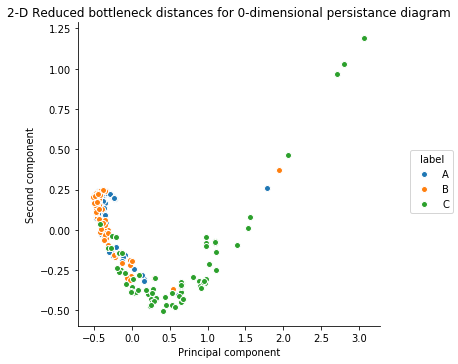

In [209]:
reduce_and_visualize(pairwise_btnck_dist_dim0, labels, 0, n_components=2)

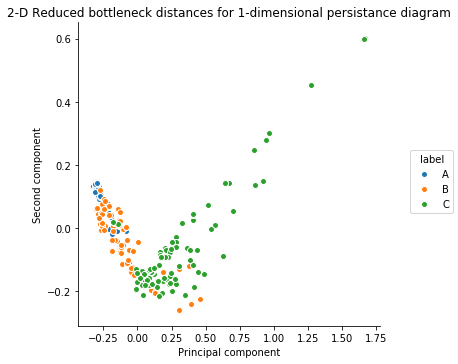

In [210]:
reduce_and_visualize(pairwise_btnck_dist_dim1, labels, 1, n_components=2)

> From the PCA in two dimensions we can already notice that the pedestrian C is quite well separated from the other two pedestrians.

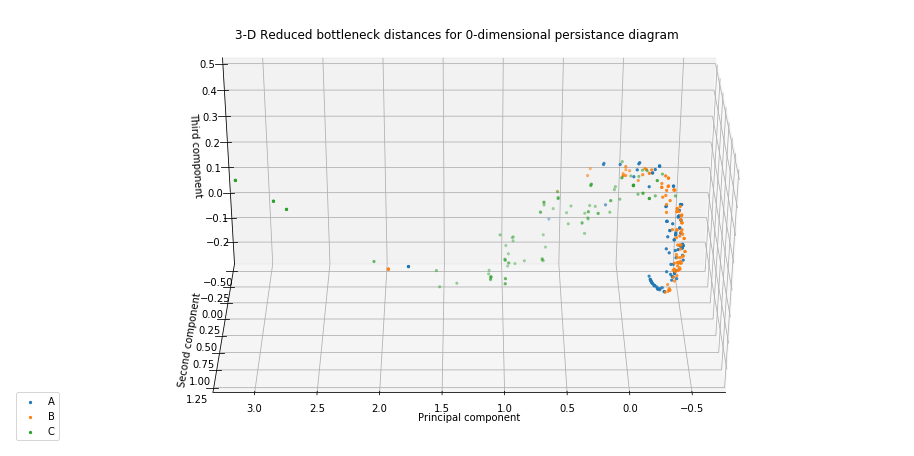

In [219]:
reduce_and_visualize(pairwise_btnck_dist_dim0, labels, 0, n_components=3)

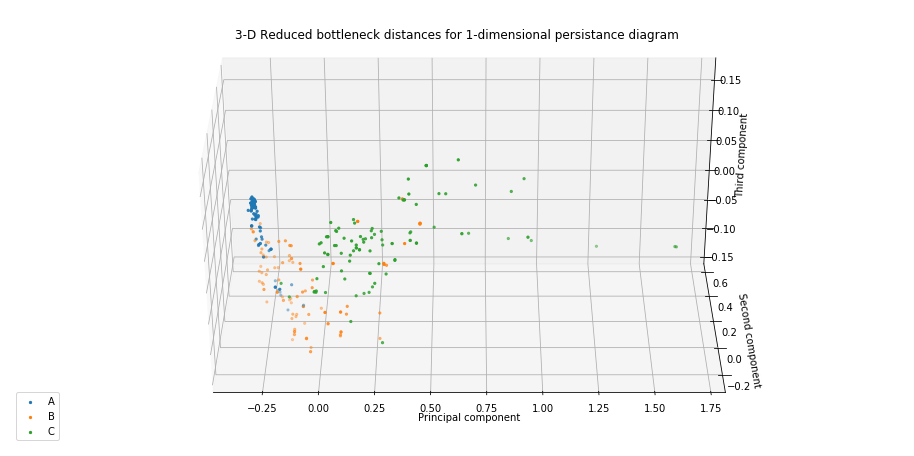

In [218]:
reduce_and_visualize(pairwise_btnck_dist_dim1, labels, 1, n_components=3, angle=270)

> The PCA in three dimensions confirms the previous observation. One can particularly distinguish between the three pedestrians in the plot corresponding to the 1-dimensional persistence diagrams. With the 0-dimensional persistence diagrams, the pedestrians A and B seem quite close however.

### Question 3
Write a function to compute persistence landscapes. This function should take as input a persistence diagram $dgm$ (in the Gudhi format), a dimension $k$, the endpoints $x_{min}; x_{max}$ of an interval, the number $n_{nodes}$
of nodes of a regular grid on the interval $[x_{min}; x_{max}]$ and a number of landscapes $n_{ld}$, and output a $n_{ld}*n_{nodes}$ array storing the values of the first $n_{ld}$ landscapes of $dgm$ on the node of the grid. Check, on some simple examples that your code is correct.

For now, the function takes a list of points represented as lists of coordinates (that we name dgm). This has been done using the function `persistence_output_to_diag`.

> We first computed the $\Lambda_p$ function, and used it to derive the suggested `persistence_landscape` function.

In [68]:
def Lambda(t, b, d):
    """Triangle induced by the point p (b, d) in the new system
    of coordinates ((d+b)/2, (d-b)/2).
    
    Parameters
    ----------
    t : float
        Point to evaluate the Lambda function on.
    b : float
        x coordinate of the point in the original persistence diagram.
    d : float
        y coordinate of the point in the original persistence diagram.
    
    Returns
    -------
    float
        Value of the Lambda function (t).
    """
    b_new = (b+d)/2
    if b <= t <= b_new:
        return t-b
    elif b_new < t <= d:
        return d-t
    else:
        return 0

In [69]:
# Vectorized function to be able to apply it on a whole array
Lambda = np.vectorize(Lambda, otypes=[float])

In [89]:
# Check if Lambda is computing the right values
def plot_Lambda_point(t, point):
    """Plot the function Lambda of given point over all t
    
    Parameters
    ----------
    t : numpy array
        Often a np.linspace()
    point : (x, y) tuple
        (b, d) coordinates in the persistence diagram
    """
    plt.title("Lambda of various points")
    plt.xlabel("t")
    plt.ylabel("lambda(t)")
    plt.scatter(t, Lambda(t, point[0], point[1]))

In [99]:
# Lambda is a tool 
def persistence_landscape(dgm, xmin, xmax, n_nodes, n_ld, plot_first=False):
    """Compute the persistence landscape on a given persistence diagram.
    
    Parameters
    ----------
    dgm : array, shape = [n_points, 2]
        Peristence diagram (e.g. 0 or 1 dimensional).
    xmin : float
        Left endpoint of the interval.
    xmax : float
        Right endpoint of the interval.
    n_nodes : int
        Number of nodes of a regular grid on the interval [xmin, xmax].
    n_ld : int
        Number of landscapes.
    plot_first : bool, optional
        If True, plot the first persistence landscape.
    
    Returns
    -------
    array, shape = [n_ld, n_nodes]
        Values of the first n_ld landscapes of dgm on the nodes of the grid.
    """
    # Number of points in the persistence diagram
    n_points = len(dgm)

    # Discretization for computing the persistence landscapes
    t = np.linspace(xmin, xmax, n_nodes)

    landscapes_by_point = np.zeros((n_points, n_nodes))

    for i in range(n_points):
        # Coordinates in the persistence diagram
        point = dgm[i]
        b = point[0]
        d = point[1]
        landscapes_by_point[i, :] = Lambda(t, b, d)
    
    # Sort the point in descending order
    landscapes = np.sort(landscapes_by_point, axis=0)[::-1]
    
    # If flag is true, plot the first persistence landscape of the point cloud
    if plot_first:
        plt.title("First persistence landscape")
        plt.xlabel("t")
        plt.ylabel("Landscape")
        plt.scatter(t, landscapes[0,:])

    # Keep only the first n_ld landscapes
    landscapes = landscapes[:n_ld, :]

    return landscapes

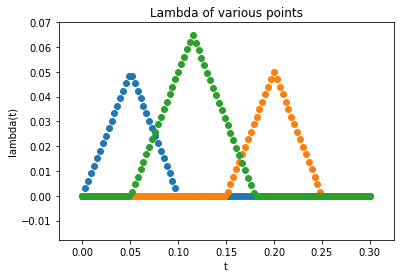

In [90]:
# Test by plotting 3 Lambda functions (of 3 points) 
t = np.linspace(0.,0.3,100)
point1 = (0, 0.1)
point2 = (0.15, 0.25)
point3 = (0.05, 0.18)

plot_Lambda_point(t, point1)
plot_Lambda_point(t, point2)
plot_Lambda_point(t, point3)

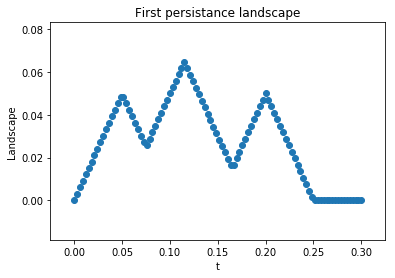

In [100]:
# Test with the 3 previous points (expect to have a crown-shaped function)

# Diagram in the gudhi format
dgm = [point1, point2, point3]
# Persistence landscape calculation
ldscp = persistence_landscape(dgm, 0, 0.3, 100, 5, plot_first=True)

> This simple example above is a sanity check for the `persistence_landscape` function. It can be safely used for now!

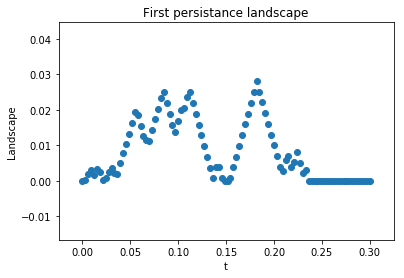

In [145]:
# Test to plot the first persistence landscape of a randomly chosen observation
# from the 1-dimensional persistence diagram dgms1
rd = np.random.randint(nb_observations)
landscape = persistence_landscape(dgms1[rd], 0, 0.3, 100, 5, plot_first=True)

### Question 4
For each 0-dimensional and 1-dimensional persistence diagrams, compute the first 5 landscapes on a relevant interval with a few hundred of nodes. Splitting randomly the data set into a 80=20 learning/test data, use a random forest to explore the performances of the 0-dimensional or 1-dimensional landscapes to classify pedestrians. Compare the results you obtain using 0-dimensional landscapes, 1-dimensional landscapes or both.

> We used previously created functions to generate features for each point cloud. By going through various examples, we fixed the parameters to $x_{min}=0, \ x_{max}=0.4, \ n_{nodes}=200, \ n_{ld}=5$. 

> As for the Machine Learning classifier model, we use a **Random Forest Classifier**, and for evaluating it, we computed the **average accuracy over 5 stratified k-folds**. Here, the classes are balanced, and the accuracy metric is well-suited to the problem. 

> We can notice that compared to the baseline of always choosing one label (~33% accuracy), the model using the raw data, without any kind of preprocessing or hyperparameter tuning, performs well. The information in the **1-dim** persistence diagram seems **capital** to get **near-perfect accuracy**.

| Model                           | Score |
|---------------------------------|-------|
| 0-dim persistence diag          | 0.85  |
| 1-dim persistence diag          | 0.99  |
| (0 and 1)-dim persistence diags | 0.96  |
| Always label A                  | 0.33  |
| Raw data (q5)                   | 0.90  |


In [155]:
# Expected shape: 300 observations x 200 time points x 3 xyz coordinates
data_all.shape

(300, 200, 3)

In [156]:
def compute_landscape_features(dgms, xmin=0, xmax=0.4, n_nodes=200, n_ld=5):
    """Compute the landscape features from the pre-computed persistence diagrams.
    
    Parameters
    ----------
    dgms : array
        Persistence diagrams.
    xmin : float
        Left endpoint of the interval.
    xmax : float
        Right endpoint of the interval.
    n_nodes : int
        Number of nodes of a regular grid on the interval [xmin, xmax].
    n_ld : int
        Number of landscapes.
    
    Returns
    -------
    array, shape = [n_observations, n_nodes]
        Persistence landscape observation matrix;
    """
    features = []

    for dgm in dgms:
        landscapes = persistence_landscape(dgm, xmin, xmax, n_nodes, n_ld).flatten()
        features.append(landscapes)

    return np.array(features)

In [157]:
# 0-dimensional persistence landscapes
features0 = compute_landscape_features(dgms0)

In [163]:
# 1-dimensional persistence landscapes 
features1 = compute_landscape_features(dgms1)

In [158]:
# Random Forest classifier
clf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [182]:
# Use only 0-dimensional persistence diagrams
X = features0
print("Mean of cross-validation accuracy: {:.2f}".format(cross_val_score(clf, X, label, cv=cv, scoring='accuracy').mean()))

Mean of cross-validation accuracy: 0.85


In [185]:
# Use only 1-dimensional persistence diagrams
X = features1
print("Mean of cross-validation accuracy: {:.2f}".format(cross_val_score(clf, X, label, cv=cv, scoring='accuracy').mean()))

Mean of cross-validation accuracy: 0.99


In [192]:
# Use both 0 and 1 dimensional persistence diagrams
X = np.append(features0, features1, axis=1)
print("Mean of cross-validation accuracy: {:.2f}".format(cross_val_score(clf, X, label, cv=cv, scoring='accuracy').mean()))

Mean of cross-validation accuracy: 0.96


### Question 5
Do the same experiment as previously, but using the raw data (3 × 200 array of acceleration coordinates). Compare the obtained classification results to the previous one.

In [105]:
print("# individuals: {}".format(len(data_A)))
print("# points along a direction: {}".format(len(data_A[0])))
print("# of directions: {}".format(len(data_A[0][0])))

print("Example of 1 individual (10 first points):\n {}".format(data_A[0][:10]))

<class 'numpy.ndarray'>
# individuals: 100
# points along a direction: 200
# of directions: 3
Example of 1 individual (10 first points):
 [[-0.01335971  2.03704449  0.45377801]
 [-0.12221272  0.98460441  0.75436414]
 [ 0.59621037  1.27607556  0.0252214 ]
 [ 0.46193014  0.55061387  0.85244704]
 [ 0.36461593  0.49541915 -0.37506861]
 [ 0.14870562  1.31868865 -0.55713249]
 [ 0.12197022  0.90864    -0.098507  ]
 [ 0.42455222  0.66980046  0.02497438]
 [ 0.30348242  0.84052907 -0.16109018]
 [ 0.22134849  0.88202865 -0.08707101]]


In [106]:
def flatten(data):
    list_result = [individual.flatten() for individual in data]
    return np.array(list_result)

In [107]:
# Flatten the list to get 100 rows of 600 points
flat_data_A = flatten(data_A)
print("# individuals: {}".format(len(flat_data_A)))
print("# points per individual: {}".format(len(flat_data_A[0])))

# individuals: 100
# points per individual: 600


In [108]:
# Concatenating data from 3 sources
flat_data_B = flatten(data_B)
flat_data_C = flatten(data_C)

X = np.concatenate((flat_data_A, flat_data_B, flat_data_C))
X.shape

(300, 600)

In [121]:
# Classifying using raw data
clf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True)
print("Mean of cross-validation accuracy: {:.2f}".format(cross_val_score(clf, X, label, cv=cv, scoring='accuracy').mean()))

Mean of cross-validation accuracy: 0.90


In [110]:
# Test on 1 specific example from A
split = next(cv.split(X,label))
(X_train, y_train) = (X[split[0]], label[split[0]])
(X_test, y_test) = (X[split[1]], label[split[1]])

### Conclusion
The suggested problem of pedestrian recognition was an "**easy**" one. Without any kind of preprocessing and without hyperparameter tuning, we were able to reach a 90% accuracy. However, we were able to see how, in a kind of problems where geometrical aspects are to be accounted for, persistence landscapes were relevant.
- By computing pairwise bottleneck distances between persistence diagrams, we were able to distinguish some clusters of points corresponding to the labels
- By computing persistence landscape-based features, we were able to reach a near-perfect score on a 5 k-fold cross-validation score
